In [42]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from livelossplot import PlotLosses
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
import math

plt.ion() 

In [4]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Scale(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=ds_trans)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=ds_trans)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/home/anton/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [7]:
use_gpu = torch.cuda.is_available()
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(trainloader))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.size()

torch.Size([32, 1000])

In [17]:
liveloss = PlotLosses()
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                #preds = outputs.data.max(1)[1]
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = float(running_loss) / dataset_sizes[phase]
                train_epoch_acc = float(running_corrects) / dataset_sizes[phase]
            else:
                valid_epoch_loss = float(running_loss) / dataset_sizes[phase]
                valid_epoch_acc = float(running_corrects) / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))
    liveloss.update({
        'Train loss': train_epoch_loss,
        #'Validation loss': valid_epoch_loss,
        'Train Accuracy': train_epoch_acc,
        #'Val Accuracy': valid_epoch_acc
    })
    liveloss.draw()

    model.load_state_dict(best_model_wts)

    return model


In [9]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with 100 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 10)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':trainloader, 'valid':valloader}

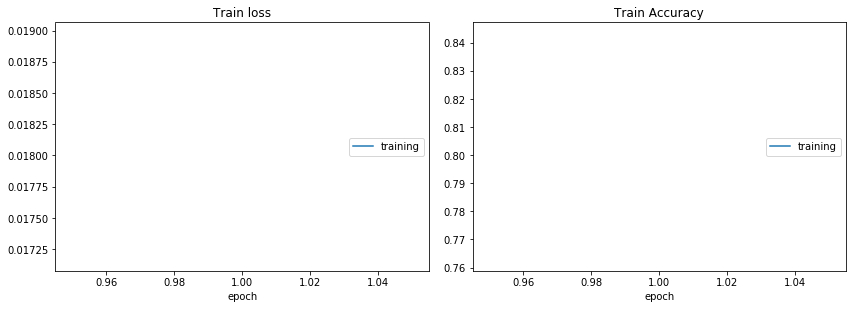

Train loss:
training   (min:    0.018, max:    0.018, cur:    0.018)

Train Accuracy:
training   (min:    0.803, max:    0.803, cur:    0.803)
Training time: 121.650877 minutes


In [19]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=100)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

In [32]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [37]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


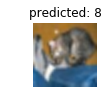

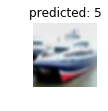

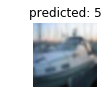

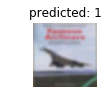

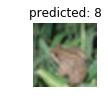

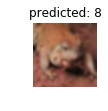

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fbc1011fa20>>
Traceback (most recent call last):
  File "/home/anton/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/anton/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/anton/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/anton/anaconda3/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfd

In [38]:
visualize_model(model)

plt.ioff()
plt.show()

In [40]:
np.__file__

'/home/anton/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'

In [43]:
int(math.floor(32 * (32 / 64.0)))

16